In [153]:
import os
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import numpy as np
from tqdm import tqdm
import re

# 증강

In [137]:
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

class CNNCustomDataset(Dataset):
    def __init__(self, file_paths, transform=None, gauss_sigma=0.05):
        self.file_paths = file_paths
        self.transform = transform
        self.gauss_sigma = gauss_sigma

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path, label = self.file_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            original_image = self.transform(image)
            noisy_image = gauss_noise(original_image, self.gauss_sigma)
            images = rotate_images(image)
            transformed_images = [self.transform(img) for img in images]
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]
            return original_image, noisy_image, transformed_images, noisy_images, label
        else:
            return image, label

In [138]:
img_size = 480

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor(), 
])


In [139]:
folder = r"D:\datacut"

data_paths = []

label_map = {
    "Bending": 0,
    "Reverse": 1,
    "Stain": 2
}

for label_name in os.listdir(folder):
    if label_name != "Good":
        label_folder = os.path.join(folder, label_name)
        for filename in os.listdir(label_folder):
            data_paths.append((os.path.join(label_folder, filename), label_map[label_name]))

In [140]:
custom_dataset = CNNCustomDataset(data_paths, transform=transform)

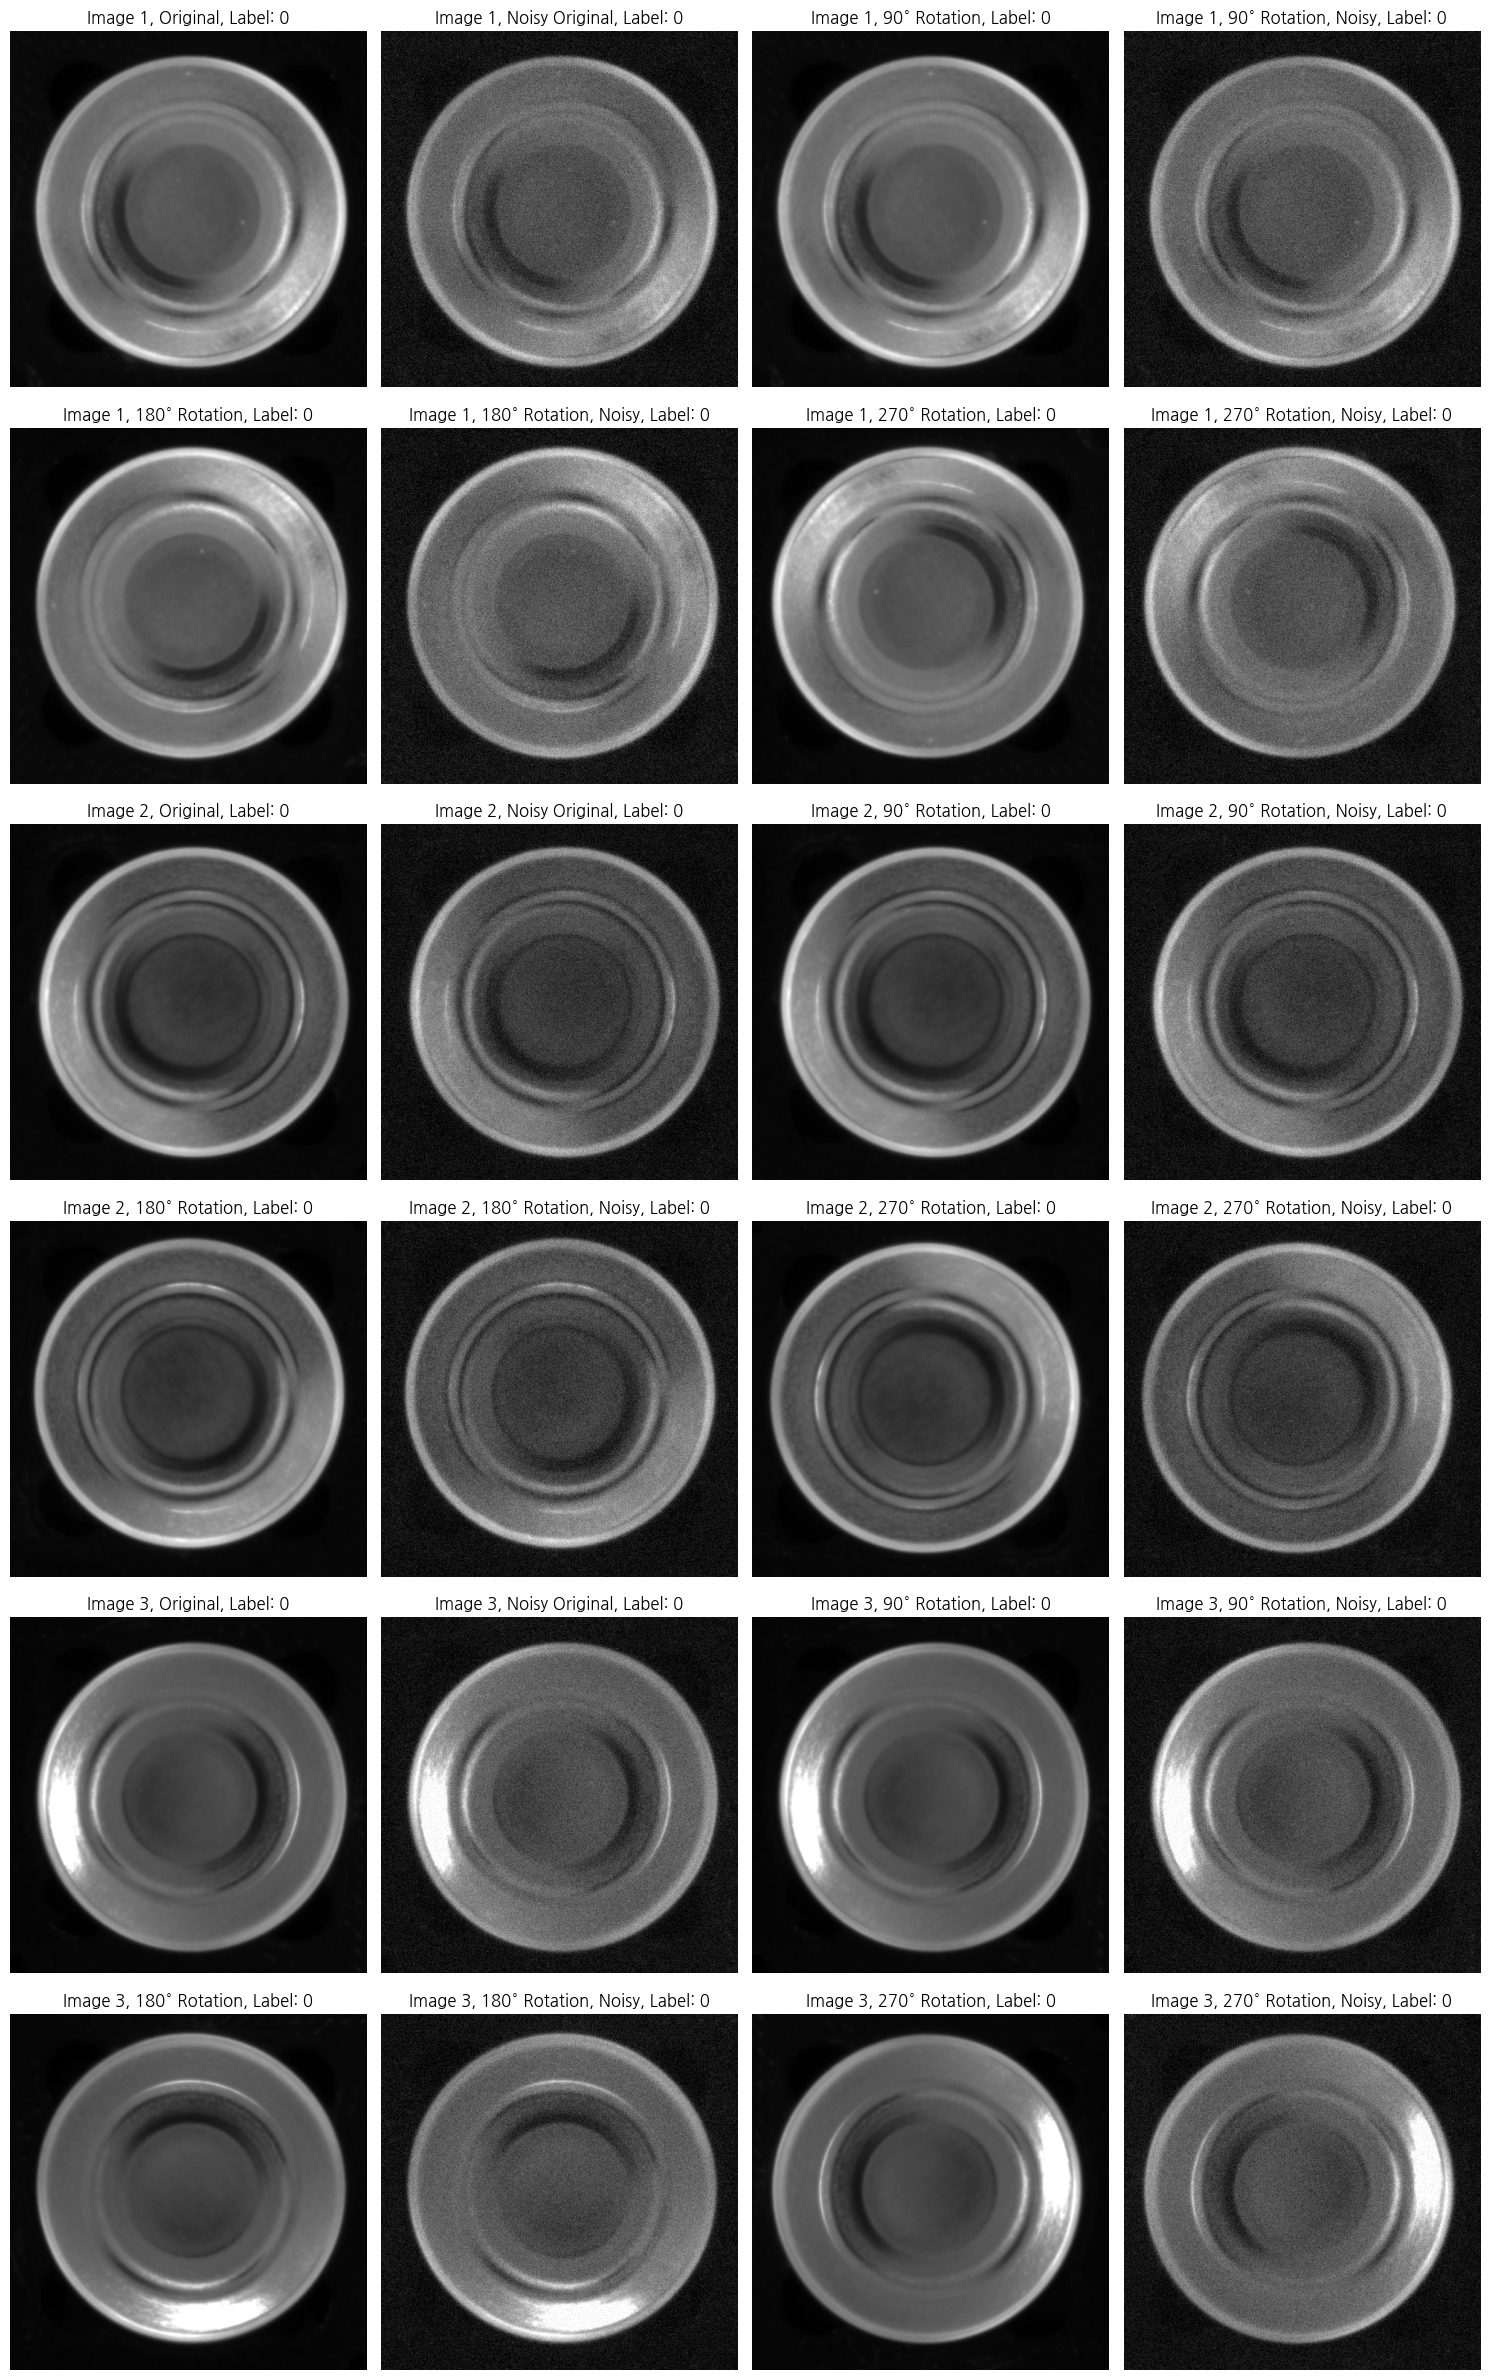

In [142]:
num_rows = 3 * 2
plt.figure(figsize=(15, num_rows * 4))
for i in range(3):
    original_image, noisy_image, transformed_images, noisy_images, label = custom_dataset[i]

    # Original Image
    plt.subplot(num_rows, 4, i * 8 + 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Original, Label: {label}')
    plt.axis('off')

    # Noisy Original Image
    plt.subplot(num_rows, 4, i * 8 + 2)
    plt.imshow(noisy_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Noisy Original, Label: {label}')
    plt.axis('off')

    # Rotated Images
    for j in range(3):
        plt.subplot(num_rows, 4, i * 8 + 3 + j * 2)
        plt.imshow(transformed_images[j].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation, Label: {label}')
        plt.axis('off')

        plt.subplot(num_rows, 4, i * 8 + 4 + j * 2)
        plt.imshow(noisy_images[j].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation, Noisy, Label: {label}')
        plt.axis('off')

plt.tight_layout()
plt.show()
